<a href="https://colab.research.google.com/github/AndreKaled/classificacao-lixo-reciclagem/blob/main/Trash_Garbage_Type_Detection_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install tensorflow matplotlib numpy pandas scikit-learn kagglehub seaborn

Note: you may need to restart the kernel to use updated packages.


In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
trashnet_path = kagglehub.dataset_download('asdasdasasdas/garbage-classification')

print('TrashNet dataset import complete.')


/home/plaaeo/uni/classificacao-lixo-reciclagem/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TrashNet dataset import complete.


<a id="tc"></a>
# Sumario
* <a href="#import">Importar bibliotecas</a>

* <a href="#read">Lendo arquivos</a>

* <a href="#gen">Geração de dados</a>

* <a href="#tt">Dividir arquivos de treino e teste</a>

* <a href="#import_model">Importar modelo e histórico</a> (se já tiver treinado)

* <a href="#arquitetura">Arquitetura da rede neural</a>

* <a href="#compilador">Compilador</a>

* <a href="#treinando">Treinando o modelo</a>

* <a href="#save">Salvando o modelo</a>

* <a href="#avaliacao">Avaliação do modelo</a>

* <a href="#use">Usando o modelo</a>

* <a href="#conclusao">Conclusão</a>


<h2 style="font-family:camtasia;
          font-size:320%;
          font-weight: bold;
          color: #029db9;
          text-shadow: 2px 2px 2px rgba(0, 0, 0, 0.3);
          text-align:center;
          margin: 0 auto;
          padding:10px; ">
        Trash Type Detection usnig CNN
    </h2>

<div style="max-width: 100%;">
  <img src="https://lepageandsons.com/wp-content/uploads/2021/04/Garbage-Depositphotos_180449132_xl-2015-1210x423.jpg" style="width: 100%; height: auto;box-shadow: 2px 2px 5px rgba(0, 0, 0, 0.5);">
</div>

<a id="import"></a>
<a href="#tc">📄 Back to Tabel of Contents</a>
   
# Importando bibliotecas

In [17]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   tensorflow import keras
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight
from   sklearn.metrics import confusion_matrix
from   IPython.display import display, Markdown
import seaborn as sns
import zipfile
from tensorflow.keras.callbacks import History
import json


In [4]:
warnings.filterwarnings("ignore")

<a href="#tc">📄 Back to Tabel of Contents</a>

<a id="read"></a>
       
# Lendo arquivos

In [5]:
data_path = trashnet_path

In [6]:
# Data Classes
print(os.listdir(data_path))

['one-indexed-files.txt', 'zero-indexed-files.txt', 'Garbage classification', 'one-indexed-files-notrash_val.txt', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_test.txt', 'garbage classification']


In [7]:
main_folder_path = Path(data_path)

all_folders = [d for d in main_folder_path.glob('**/') if d.is_dir()]

# Count number of files in each class
data = []
for folder in all_folders:
    folder_name = folder.name
    file_count = len(list(folder.glob('*.*')))
    if folder_name != data_path:
        data.append({'Folder Name': folder_name, 'File Count': file_count})

count = pd.DataFrame(data)

count = count.set_index('Folder Name')
count

,File Count
Folder Name,
2,5
Garbage classification,0
garbage classification,0
Garbage classification,0
paper,594
cardboard,403
metal,410
trash,137
plastic,482


In [8]:
print(f'Total {count.sum()}')

Total File Count    5059
dtype: int64


In [9]:
# Show five image of each class
def plot_imgs(item_dir, top=10):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(item_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(os.path.basename(item_dir))

In [10]:
# entra na pasta certa, contendo as pastas com as imagens
print(os.listdir(os.path.join(data_path, 'Garbage classification')))
data_path = os.path.join(data_path, 'Garbage classification')
data_path = os.path.join(data_path, 'Garbage classification')

['Garbage classification']


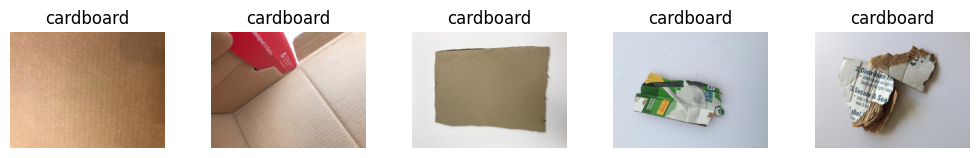

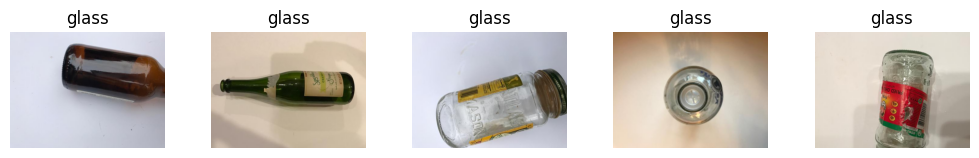

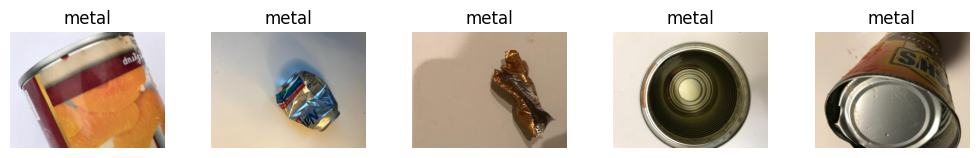

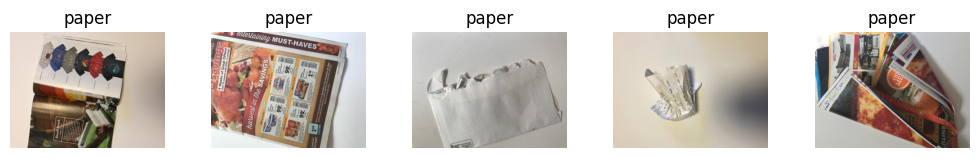

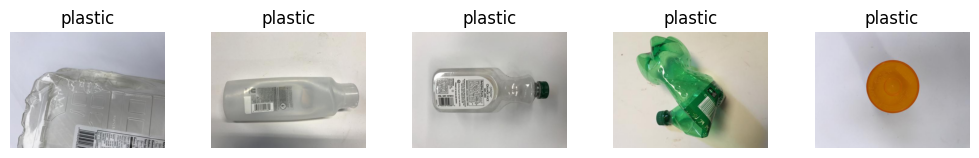

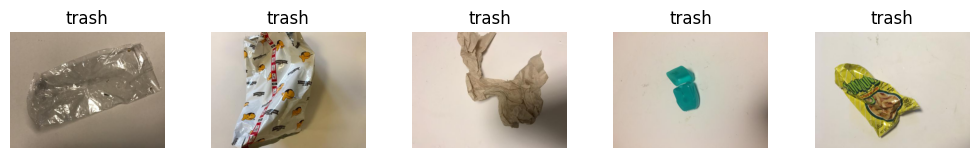

In [11]:
plot_imgs(data_path+'/cardboard')
plot_imgs(data_path+'/glass')
plot_imgs(data_path+'/metal')
plot_imgs(data_path+'/paper')
plot_imgs(data_path+'/plastic')
plot_imgs(data_path+'/trash')

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="gen"></a>
       
# Geração de dados

In [12]:
# Define variable for requirements
batch_size = 30
target_size = (224, 224)
validation_split = 0.15

In [13]:
# Data Generators
train_img_generator = ImageDataGenerator(rescale=1./255,
                                         validation_split=validation_split,
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         zoom_range = 0.5,
                                         width_shift_range = 0.3,
                                         height_shift_range = 0.3,
                                         rotation_range=50,
                                         shear_range = 0.3,
                                         fill_mode='nearest'
                                        )

test_data_img_generator = ImageDataGenerator(rescale=1./255,
                                             validation_split=validation_split
                                            )

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="tt"></a>
       
# Dividir arquivos de treino e teste

In [14]:
# Separate train Data
train_data = train_img_generator.flow_from_directory(data_path,
                                                        subset="training",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 2150 images belonging to 6 classes.


In [15]:
# Separate validation Data
test_data = test_data_img_generator.flow_from_directory(data_path,
                                                        subset="validation",
                                                        seed=133,
                                                        target_size=target_size,
                                                        batch_size=batch_size,
                                                        class_mode='categorical',
                                                        color_mode='rgb',
                                                       )

Found 377 images belonging to 6 classes.


<a id="import_model"></a>
<a href="#tc">📄 Back to Tabel of Contents</a>

# Importando modelo pré-treinado
Se houver um modelo pré-treinado salvo, monte o modelo com o código abaixo e já faça os <a href="#avaliacao">testes</a>. Se desejar continuar o treinamento, recompile e siga o treinamento de onde foi parado.

In [24]:
arquivoZip = "classificador_lixo.zip"
nomeModelo = "classificador_lixo.keras"
nomeHistory = "history.json"

with zipfile.ZipFile(arquivoZip, "r") as z:
    z.extractall("modelo")

model = keras.models.load_model("modelo/" + nomeModelo)
print("Modelo carregado com sucesso!")

try:
    global history
    with open(f"modelo/{nomeHistory}", "r") as f:
        history_file = json.load(f)

    history = History()
    history.history = history_file
    print("History carregado com sucesso!")
except FileNotFoundError as e:
    display(Markdown(
        "### Não foi possível carregar o history.\n" +
        "Caso queira **apenas executar o modelo**, ignore o erro abaixo e pule para a seção [*Usando o Modelo*](#use)."
    ))
    raise e


Modelo carregado com sucesso!


### Não foi possível carregar o history.
Caso queira **apenas executar o modelo**, ignore o erro abaixo e pule para a seção [*Usando o Modelo*](#use).

FileNotFoundError: [Errno 2] No such file or directory: 'modelo/history.json'

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="arquitetura"></a>
       
# Arquitetura da rede neural
Convolução -> Relu -> MaxPoolling (3 vezes)

Flatten -> Dense -> Dropout -> Dense -> softmax

Execute o código abaixo apenas **se for iniciar** o treinamento de um novo modelo.

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(Dense(6, activation='softmax'))

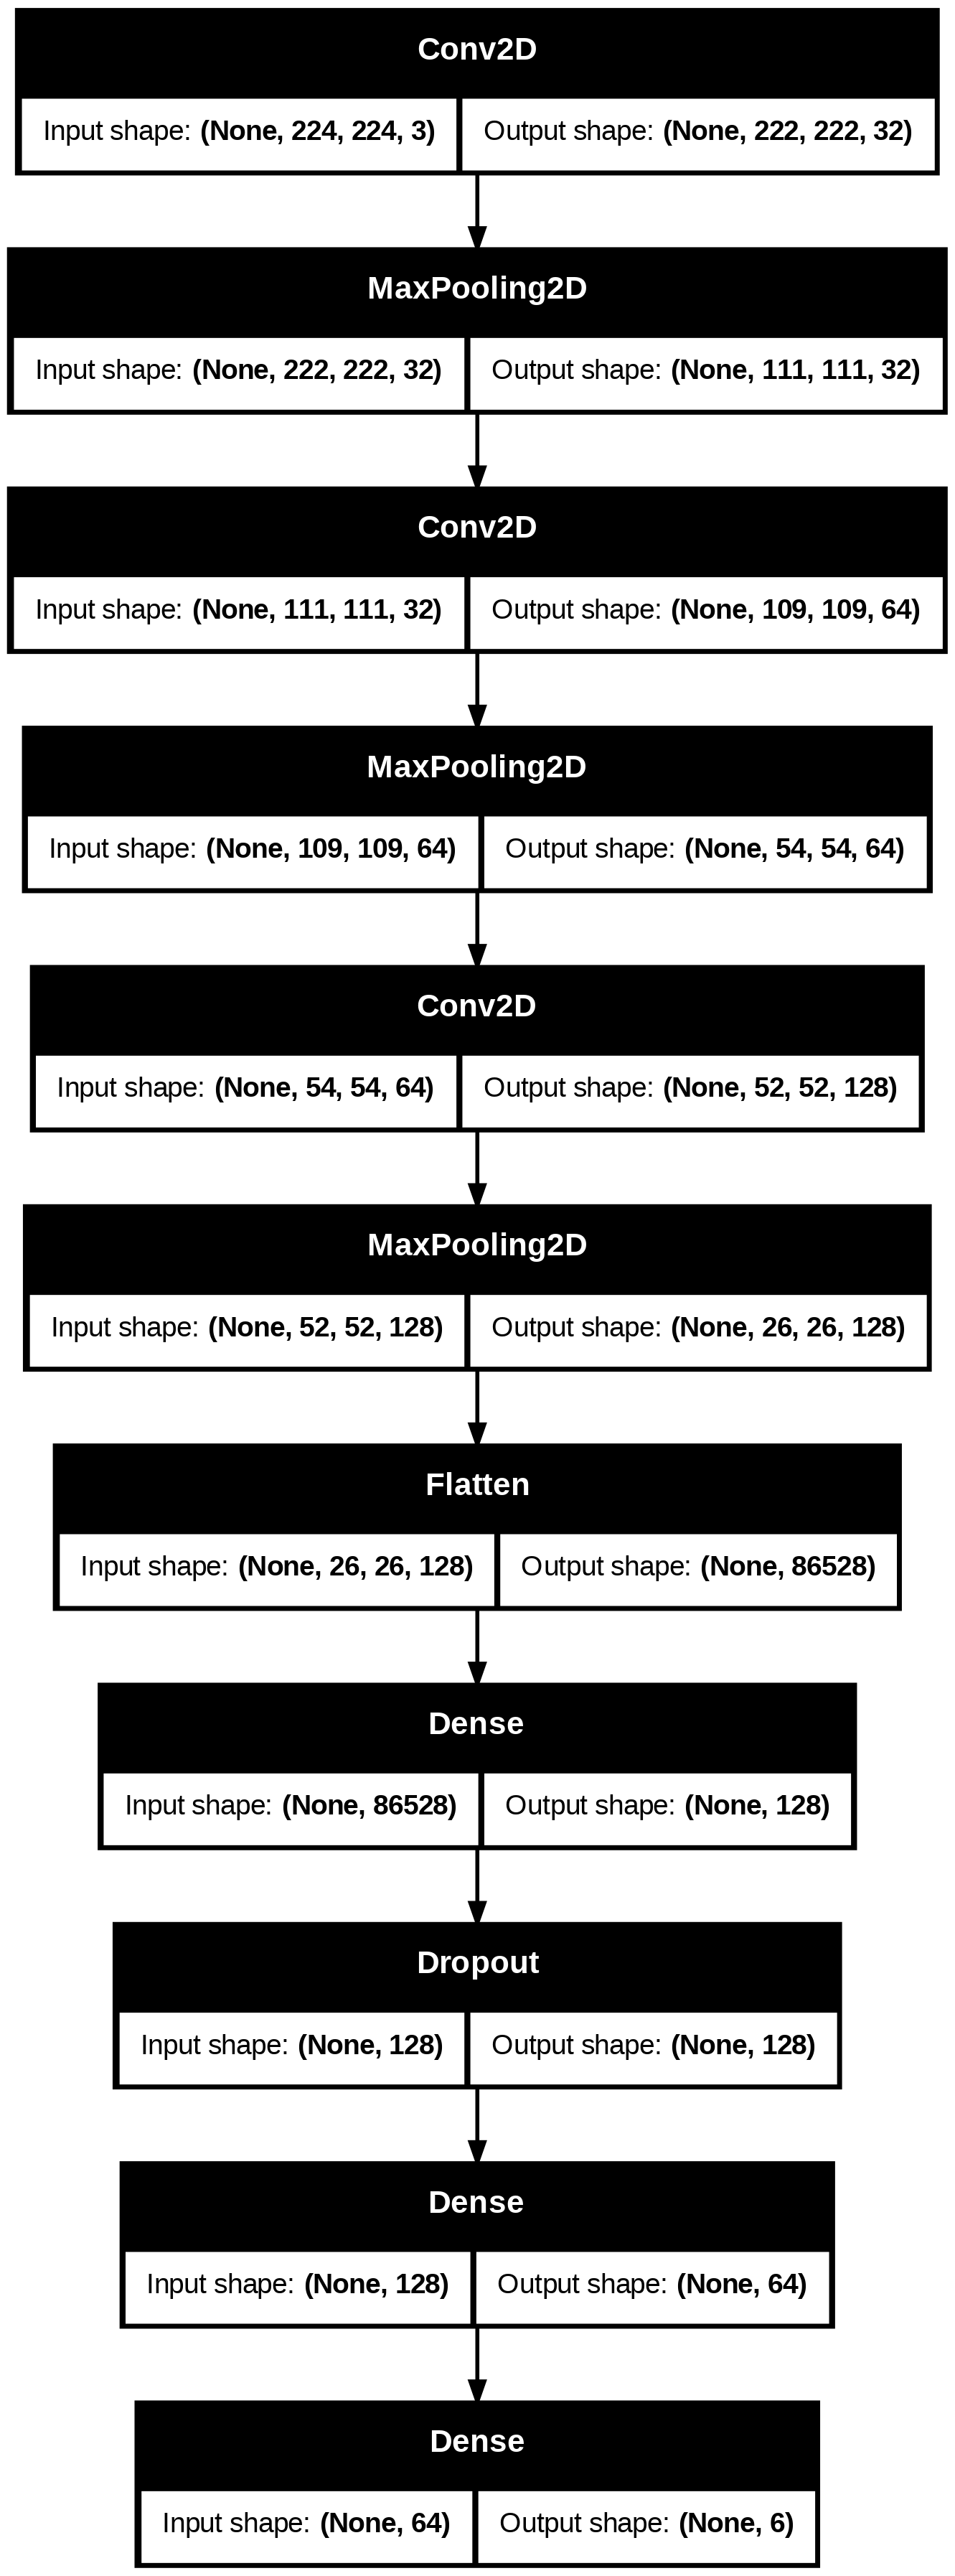

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="compilador"></a>
       
# Compilador

In [ ]:
ES = EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [ ]:
RLROP = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.1, min_lr=0.01)

In [ ]:
MCH = ModelCheckpoint('trash.h5', monitor='val_loss', mode='min', save_best_only=True)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
             )

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="treinando"></a>
       
# Treinando o modelo

In [ ]:
history = model.fit(train_data,
                    steps_per_epoch=len(train_data),
                    epochs=500,
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[ES, RLROP, MCH]
                   )

Epoch 1/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 682ms/step - categorical_accuracy: 0.2386 - loss: 2.1112

72/72 ━━━━━━━━━━━━━━━━━━━━ 63s 775ms/step - categorical_accuracy: 0.2386 - loss: 2.1070 - val_categorical_accuracy: 0.2918 - val_loss: 1.6513 - learning_rate: 0.0010
Epoch 2/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/step - categorical_accuracy: 0.3390 - loss: 1.6052

72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 464ms/step - categorical_accuracy: 0.3394 - loss: 1.6044 - val_categorical_accuracy: 0.3528 - val_loss: 1.5200 - learning_rate: 0.0010
Epoch 3/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 473ms/step - categorical_accuracy: 0.3578 - loss: 1.5286 - val_categorical_accuracy: 0.3369 - val_loss: 1.5295 - learning_rate: 0.0010
Epoch 4/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - categorical_accuracy: 0.3924 - loss: 1.4679

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - categorical_accuracy: 0.3923 - loss: 1.4679 - val_categorical_accuracy: 0.3501 - val_loss: 1.4847 - learning_rate: 0.0010
Epoch 5/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 453ms/step - categorical_accuracy: 0.4020 - loss: 1.4467 - val_categorical_accuracy: 0.3130 - val_loss: 1.5356 - learning_rate: 0.0010
Epoch 6/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - categorical_accuracy: 0.4216 - loss: 1.3926 - val_categorical_accuracy: 0.3342 - val_loss: 1.5392 - learning_rate: 0.0010
Epoch 7/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - categorical_accuracy: 0.4495 - loss: 1.3812

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 486ms/step - categorical_accuracy: 0.4497 - loss: 1.3809 - val_categorical_accuracy: 0.4111 - val_loss: 1.3783 - learning_rate: 0.0010
Epoch 8/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - categorical_accuracy: 0.4551 - loss: 1.3681

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 479ms/step - categorical_accuracy: 0.4553 - loss: 1.3676 - val_categorical_accuracy: 0.4350 - val_loss: 1.3436 - learning_rate: 0.0010
Epoch 9/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - categorical_accuracy: 0.4645 - loss: 1.3410

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 472ms/step - categorical_accuracy: 0.4649 - loss: 1.3402 - val_categorical_accuracy: 0.4430 - val_loss: 1.3193 - learning_rate: 0.0010
Epoch 10/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - categorical_accuracy: 0.5101 - loss: 1.2636

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 483ms/step - categorical_accuracy: 0.5100 - loss: 1.2638 - val_categorical_accuracy: 0.4748 - val_loss: 1.3019 - learning_rate: 0.0010
Epoch 11/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step - categorical_accuracy: 0.4908 - loss: 1.2706

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 485ms/step - categorical_accuracy: 0.4910 - loss: 1.2706 - val_categorical_accuracy: 0.4881 - val_loss: 1.2919 - learning_rate: 0.0010
Epoch 12/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step - categorical_accuracy: 0.5333 - loss: 1.2139

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 479ms/step - categorical_accuracy: 0.5331 - loss: 1.2142 - val_categorical_accuracy: 0.4828 - val_loss: 1.2866 - learning_rate: 0.0010
Epoch 13/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - categorical_accuracy: 0.5193 - loss: 1.2480 - val_categorical_accuracy: 0.4403 - val_loss: 1.4066 - learning_rate: 0.0010
Epoch 14/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - categorical_accuracy: 0.5389 - loss: 1.1949

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 473ms/step - categorical_accuracy: 0.5390 - loss: 1.1950 - val_categorical_accuracy: 0.4987 - val_loss: 1.2156 - learning_rate: 0.0010
Epoch 15/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 470ms/step - categorical_accuracy: 0.5452 - loss: 1.2150 - val_categorical_accuracy: 0.4483 - val_loss: 1.3234 - learning_rate: 0.0010
Epoch 16/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 476ms/step - categorical_accuracy: 0.5272 - loss: 1.2017 - val_categorical_accuracy: 0.5040 - val_loss: 1.2925 - learning_rate: 0.0010
Epoch 17/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 468ms/step - categorical_accuracy: 0.5186 - loss: 1.2016 - val_categorical_accuracy: 0.5040 - val_loss: 1.2535 - learning_rate: 0.0010
Epoch 18/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 470ms/step - categorical_accuracy: 0.5613 - loss: 1.1780 - val_categorical_accuracy: 0.4005 - val_loss: 1.4591 - learning_rate: 0.0010
Epoch 19/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - categorical_accuracy: 0.5251 - loss: 1.2061

72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 489ms/step - categorical_accuracy: 0.5254 - loss: 1.2054 - val_categorical_accuracy: 0.5411 - val_loss: 1.1852 - learning_rate: 0.0010
Epoch 20/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 459ms/step - categorical_accuracy: 0.5890 - loss: 1.1158 - val_categorical_accuracy: 0.5146 - val_loss: 1.2851 - learning_rate: 0.0010
Epoch 21/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 473ms/step - categorical_accuracy: 0.5867 - loss: 1.0868 - val_categorical_accuracy: 0.5040 - val_loss: 1.2722 - learning_rate: 0.0010
Epoch 22/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 469ms/step - categorical_accuracy: 0.5758 - loss: 1.1091 - val_categorical_accuracy: 0.5119 - val_loss: 1.2318 - learning_rate: 0.0010
Epoch 23/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 33s 455ms/step - categorical_accuracy: 0.5721 - loss: 1.1152 - val_categorical_accuracy: 0.5544 - val_loss: 1.2615 - learning_rate: 0.0010
Epoch 24/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - categorical_accuracy: 0.5709 - loss: 1.0847 - val_categorical

72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 471ms/step - categorical_accuracy: 0.5983 - loss: 1.0804 - val_categorical_accuracy: 0.5411 - val_loss: 1.1432 - learning_rate: 0.0010
Epoch 28/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 487ms/step - categorical_accuracy: 0.5654 - loss: 1.1435 - val_categorical_accuracy: 0.5199 - val_loss: 1.2913 - learning_rate: 0.0010
Epoch 29/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 34s 474ms/step - categorical_accuracy: 0.5853 - loss: 1.1120 - val_categorical_accuracy: 0.4934 - val_loss: 1.3213 - learning_rate: 0.0010
Epoch 30/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 483ms/step - categorical_accuracy: 0.5452 - loss: 1.1695 - val_categorical_accuracy: 0.5332 - val_loss: 1.1822 - learning_rate: 0.0010
Epoch 31/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 482ms/step - categorical_accuracy: 0.6260 - loss: 1.0369 - val_categorical_accuracy: 0.5464 - val_loss: 1.1522 - learning_rate: 0.0010
Epoch 32/500
72/72 ━━━━━━━━━━━━━━━━━━━━ 35s 483ms/step - categorical_accuracy: 0.6240 - loss: 0.9993 - val_categorical

<a id="save"></a>
<a href="#tc">📄 Back to Tabel of Contents</a>


# Salvando o modelo

Execute o código abaixo se quiser exportar e baixar o modelo para usá-lo depois

In [ ]:
import json
import zipfile

model.save("classificador_lixo.keras")

with open("history.json", "w") as f:
    json.dump(history.history, f)

with zipfile.ZipFile("classificador_lixo.zip", "w", zipfile.ZIP_DEFLATED) as z:
    z.write("classificador_lixo.keras")
    z.write("history.json")

print("Arquivo classificador_lixo.zip criado com sucesso!")


Arquivo classificador_lixo.zip criado com sucesso!


In [ ]:
# baixando o modelo (baixa só se quiser)
from google.colab import files
files.download("/content/classificador_lixo.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="avaliacao"></a>
       
# Avaliação do modelo

In [16]:
best_score = max(history.history['val_categorical_accuracy'] )
print(f"Best Validation score is: {best_score}")

Best Validation score is: 0.5543766617774963


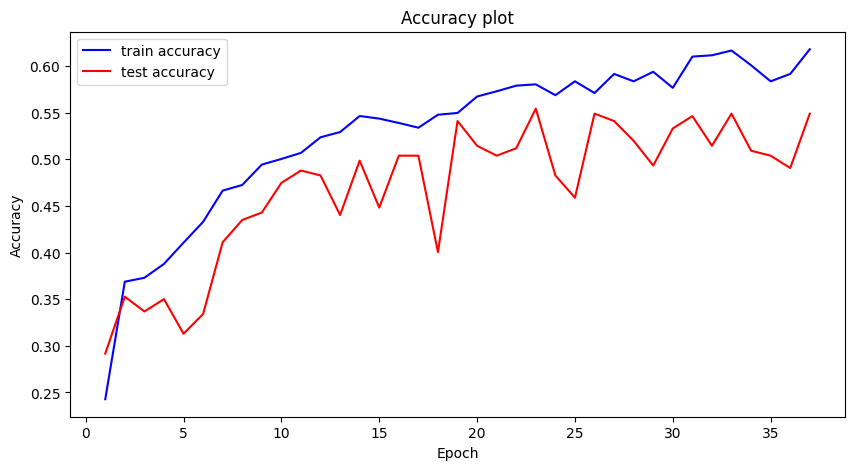

In [ ]:
# Accuracy on train data :
accuracy = history.history['categorical_accuracy']

# Accuracy on test data :
val_accuracy = history.history['val_categorical_accuracy']
epochs = range(1, len(accuracy) + 1)  # Epochs

# Accuracy line plot :
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'b', label='train accuracy')
plt.plot(epochs, val_accuracy, 'r', label='test accuracy')
plt.title('Accuracy plot')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="use"></a>
       
# Usando o modelo

In [25]:
classes = train_data.class_indices
classes

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [26]:
print(os.listdir(data_path))

['paper', 'cardboard', 'metal', 'trash', 'plastic', 'glass']


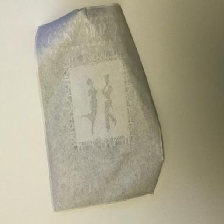

In [35]:
img = utils.load_img(
    data_path +'/paper/paper70.jpg',
    color_mode='rgb',
    target_size=(224, 224),
    interpolation='nearest',
    keep_aspect_ratio=False
)

img

In [36]:
img = utils.img_to_array(img)
img = img / 255.0    # Normalize the image

result = model.predict(tf.expand_dims(img, axis=0))

classes = train_data.class_indices

for key, value in classes.items():
    if value == np.argmax(result):
        print(key)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
paper


2025-11-16 14:40:48.162791: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378501120 exceeds 10% of free system memory.


 1/13 ━━━━━━━━━━━━━━━━━━━━ 9s 796ms/step

2025-11-16 14:40:48.543675: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378501120 exceeds 10% of free system memory.


 2/13 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step

2025-11-16 14:40:48.990764: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378501120 exceeds 10% of free system memory.


 3/13 ━━━━━━━━━━━━━━━━━━━━ 4s 437ms/step

2025-11-16 14:40:49.417222: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378501120 exceeds 10% of free system memory.


 4/13 ━━━━━━━━━━━━━━━━━━━━ 3s 440ms/step

2025-11-16 14:40:49.864634: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 378501120 exceeds 10% of free system memory.


13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 421ms/step


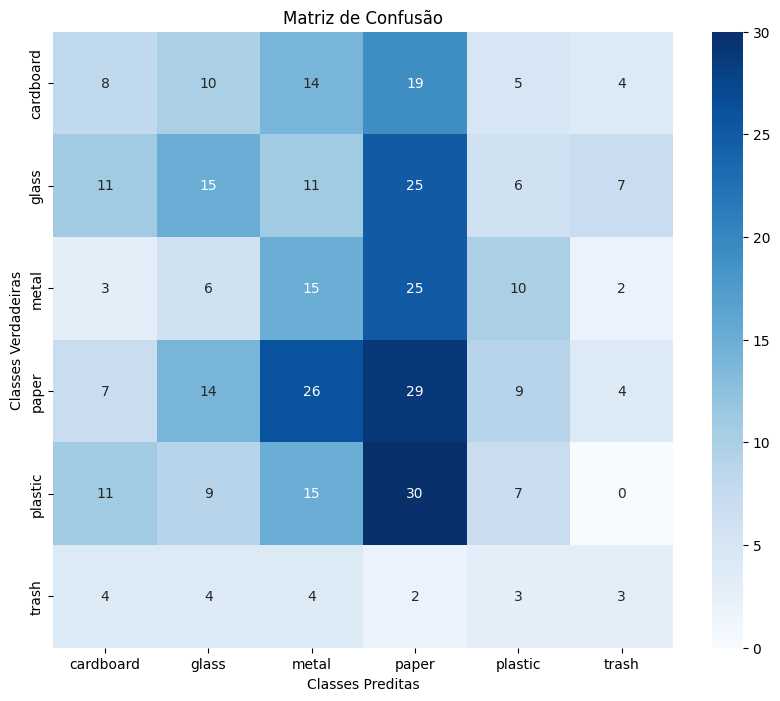

In [37]:
# Resetar o gerador de dados de teste
test_data.reset()

# Excecutar o classificador nos dados de teste e obter classes preditas
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

# Obter classes verdadeiras dos dados de teste
true_classes = test_data.classes

# Obter os rótulos das classes
class_labels = list(test_data.class_indices.keys())

# Computar e plotar a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Classes Preditas')
plt.ylabel('Classes Verdadeiras')
plt.title('Matriz de Confusão')
plt.show()

<a href="#tc">📄 Back to Tabel of Contents</a>
<a id="conclusao"></a>

# Conclusão

Neste notebook, aplicamos técnicas de aumento de dados (data augmentation) como inversão horizontal e vertical, zoom, deslocamento, rotação e cisalhamento nas imagens de treinamento. O aumento de dados desempenha um papel crucial no treinamento de modelos de aprendizado profundo, especialmente quando o conjunto de dados é limitado.

Ao criar novas variações das imagens existentes, o modelo é exposto a uma gama mais ampla de cenários de dados. Isso o ajuda a aprender características mais robustas e a generalizar melhor para dados não vistos, em vez de memorizar as imagens de treinamento, reduzindo o overfitting. Ao treiná-lo em imagens com diferentes orientações, escalas ou posições, o modelo se torna mais robusto a pequenas variações que podem ocorrer em um ambiente real, melhorando sua performance em cenários práticos.

A estratégia de aumento de dados foi fundamental para melhorar a capacidade do modelo de detectar diferentes tipos de lixo com maior precisão e confiabilidade, mitigando os desafios de um dataset de tamanho moderado.